In this notebook, I applied the KMeans and Agglomerative Clustering models to segment (cluster) customers' credit cards. I performed several data preprocessing measurements on the dataset before feeding it to the models. Feature selection, dimensionality reduction, standardization, and normalization techniques are implemented to find the best set of features for building a model with high performance. After building the models, I evaluated models' performance with different `K` values (number of clusters) in terms of inertia, Silhouette score, Calinski Harabasz score, and Davies Bouldin Score. 

# Table of contents

* Data inspection:
    * information table of the features 
    * histograms of the features 
    * missing values 
    * heatmap plot to show the correlation among the features

* Data preprocessing:
    * impute missing values
    * feature selection using Spearman correlation
    * normalization
    * standardization
    * Principal Component Analysis (PCA) for dimensionality reduction
* K-means:
    * performance evaluation for several `K`-values in terms of inertia, Silhouette score, Calinski Harabasz score, and Davies Bouldin Score 
    * applying K-means for one optimal value of `k` 
* Agglomerative Clustering
    * performance evaluation for several `K`-values in terms of Silhouette score, Calinski Harabasz score, and Davies Bouldin Score 
    * applying Agglomerative Clustering for one optimal value of `k` 



In [ ]:
# imports
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


## **$\color{darkorange}{\text{Step 1:}}$** Loading the data

In [ ]:
# upload data
def readData(fileName):
  uploaded = files.upload()
  dataFrame = pd.read_csv(fileName)
  return dataFrame 

In [ ]:
credit_cards = readData("Credit Cards.csv")

Saving Credit Cards.csv to Credit Cards (1).csv


## **$\color{darkorange}{\text{Step 2:}}$** Data inspection

In [ ]:
credit_cards.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
# information table: the name of features, the number of their no-null values, and datatype 
credit_cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [ ]:
# drop the 'CUST_ID' feature because it's redundant
credit_cards = credit_cards.drop('CUST_ID', axis=1)

In [ ]:
"""
this function draws the histogram for the features. 
By looking at these plots, we can see what is the range of each feature, and how they are distributed
"""
def histogram(dataFrame):
  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
  for i in range(4):
      for j in range(4):
          sns.histplot(dataFrame[dataFrame.columns[4 * i + j]], color='darkgreen', ax=axs[i,j])       
  plt.show()
  sns.histplot(dataFrame.TENURE, color='darkgreen') 

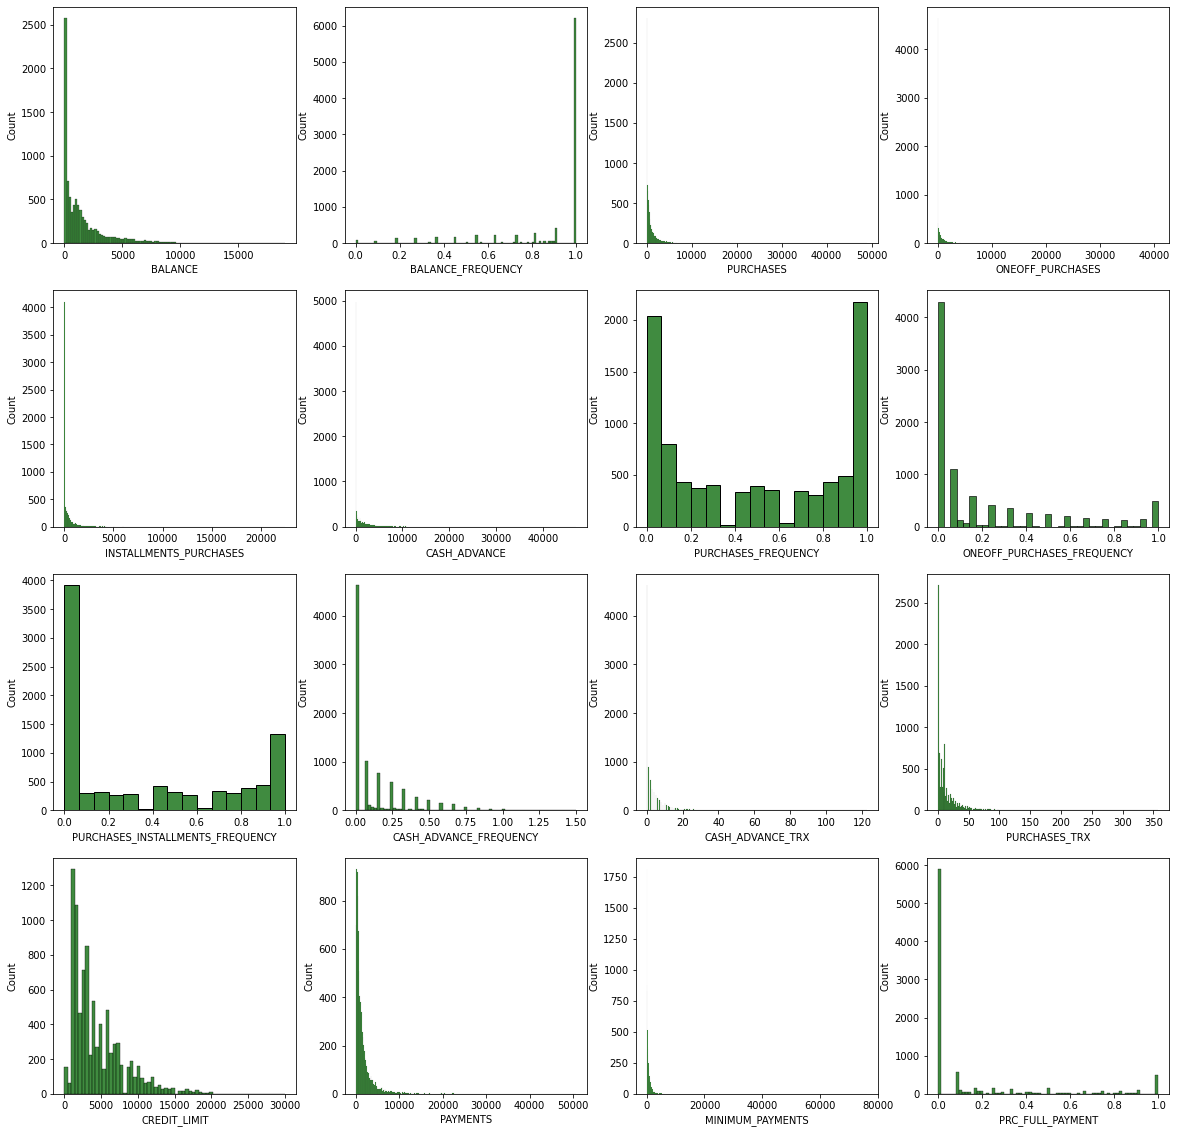

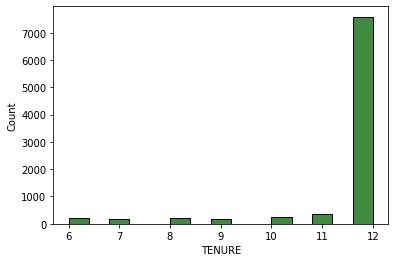

In [ ]:
histogram(credit_cards)

In [ ]:
# number of missing values of each feature 
credit_cards.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [ ]:
"""
This function draws the Spearman correlation heatmap for the dataset. 
Spearman’s correlation coefficient is a statistical measure of the strength of a
monotonic relationship between pair of features. This value is between -1 and 1. A 
value of +1 means a perfect association of rank. a value of 0 means no association of ranks
and a value of -1 means a perfect negative association between ranks.
"""
def heatmap(dataFrame):
  plt.figure(figsize=(24, 7))
  corr = dataFrame.corr(method='spearman')
  columns = np.full((corr.shape[0],), True, dtype=bool)
  sns.heatmap(corr, cmap="YlGnBu", annot=True)

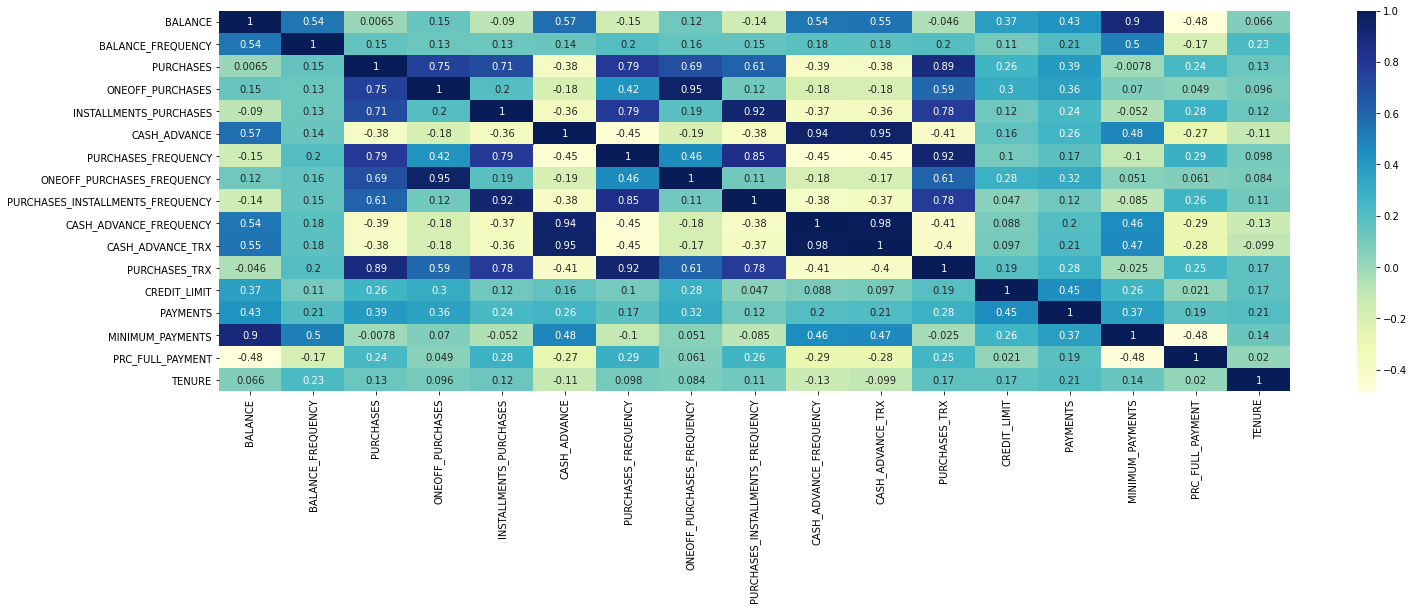

In [ ]:
heatmap(credit_cards)

From the heatmap above, we can see what features are highly correlated: BALANCE and MINIMUM_PAYMENTS, PURCHASES and PURCHASES_TRX, ONEOFF_PURCHASES and ONEOFF_PURCHASES_FREQUENCY, and so on. Basically, we can say that features with Spearman coefficient near and larger than 0.9, are highly correlated. 

##**$\color{darkorange}{\text{Step 3:}}$** Data preprocessing 

In [ ]:
"""
Data preprocessing class: implements data cleaning, feature selection, dimensionality reduction, standardization, and normalization.
"""
class data_preproccessing:

  # initialization method
  def __init__(self, data):
    self.dataFrame = data

  # imputes missing values by a new level or by the 'mean' of the feature
  def missing_values(self):
    features = self.dataFrame.columns
    for i in features:
      num = self.dataFrame[i].isnull().sum()
      if num:
        self.dataFrame[i].fillna(self.dataFrame[i].mean(), inplace=True)

  # performs feature selection using Spearman correlation coefficients 
  def feature_selection(self):
    corr = self.dataFrame.corr(method='spearman')
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:  
          columns[j] = False
    selected_columns = self.dataFrame.columns[columns]
    dataFrame_selection = self.dataFrame[selected_columns]
    return dataFrame_selection

  # performs data normalization 
  def normalization(self):
    norm = MinMaxScaler().fit(self.dataFrame)
    dataFrame_norm = norm.transform(self.dataFrame) 
    return dataFrame_norm

  # performs data standardization 
  def standization(self):
    stand = StandardScaler().fit(self.dataFrame)
    dataFrame_stand = stand.transform(self.dataFrame)
    return dataFrame_stand

  # performs PCA for dimensionality reduction
  def PCA_dim_reduction(self, num):
    pca = PCA(n_components = num) 
    dataFrame_principal = pca.fit_transform(self.standization()) 
    dataFrame_principal = pd.DataFrame(dataFrame_principal)   
    return dataFrame_principal

In [ ]:
"""
Here, I initiate an object of the data_preproccessing and pass the credit_cards dataframe to it.
I call several methods to performs our desired data preprocessing measurements.
Note, feature selectuon is done when we have a large number of features, and we want to get ride of redundant features.
In this task the number of features is not large, but I have just explored it to make my work more interesting.      
""" 
DP = data_preproccessing(credit_cards)
DP.missing_values()
DP.feature_selection()
df = DP.dataFrame

## **$\color{darkorange}{\text{Step 4:}}$** KMeans 

Now that I have the data ready to be fed to the model, I apply the KMeans algorithm and evaluate it using four metrics:
* Inertia: computes the sum of distances of all the points within a cluster from the centroid of that cluster. The lower values are better and zero is optimal.
* Silhouette score: measures the distance between each data point, the centroid of the cluster it was assigned to, and the closest centroid belonging to another cluster. The best value is 1 and the worst value is -1 and values near 0 indicate overlapping clusters.
* Calinski Harabasz score: the ratio between the within-cluster dispersion and the between-cluster dispersion. The higher the value, the better is the solution.
* Davies Bouldin score: the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. The minimum score is zero, with lower values indicating better clustering.

In [ ]:
"""
This evaluates KMeans for a range of K values and draws the performance plots in terms of four metrics
"""
def evaluatation_metrics_for_KMeans(df, min_clust, max_clust):
  inertias = []
  silhouette = []
  ch_score = []
  db_score = []
  # KMeans clusters the data for different k values 
  for n_clust in range(min_clust, max_clust):
      kmeans = KMeans(n_clusters=n_clust)
      label = kmeans.fit_predict(df)
      # strong the scores in seprate lists 
      inertias.append(kmeans.inertia_)
      silhouette.append(silhouette_score(df, label))
      ch_score.append(calinski_harabasz_score(df, label))
      db_score.append(davies_bouldin_score(df, label)) 

  # drawing the performance in terms of each metric as per of each K value 
  metric_values = {0:inertias, 1:silhouette, 2:ch_score, 3:db_score}
  metric_names =  ['Inertia', 'Silhouette Score','Calinski Harabasz Score', 'Davies Bouldin Score']
  fig, ax = plt.subplots(2, 2, figsize=(15, 10))
  for i in range(2):
    for j in range(2):
      ax[i][j].plot(range(min_clust, max_clust), metric_values[2*i+j], 'bx-', linewidth=2, color='darkgreen')
      ax[i][j].set_xlabel('Number of clusters')
      ax[i][j].set_ylabel(metric_names[2*i+j])
  plt.show()

  # prints a table that shows best K values associated with each metric 
  print(' Metric\t\t\t\t Best_K\t Score\n','---'*20)
  print(' Inertia\t\t\t %d\t %.3f\n' %(inertias.index(min(inertias))+2, min(inertias))) 
  print(' Silhouette Score\t\t %d\t %.3f\n' %(silhouette.index(max(silhouette))+2, max(silhouette))) 
  print(' Calinski Harabasz Score\t %d\t %.3f\n' %(ch_score.index(max(ch_score))+2, max(ch_score))) 
  print(' Davies Bouldin Score\t\t %d\t %.3f\n' %(db_score.index(min(db_score))+2, min(db_score))) 


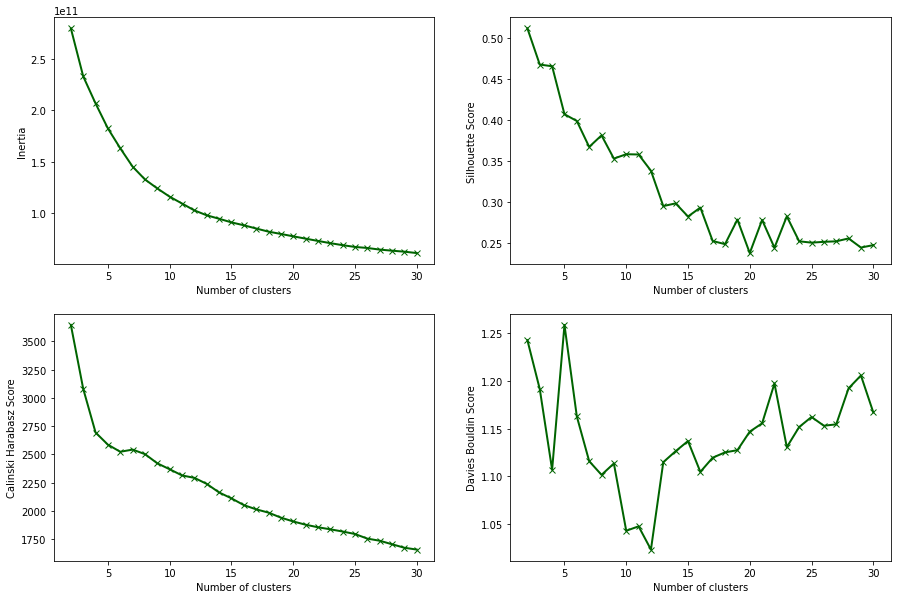

 Metric				 Best_K	 Score
 ------------------------------------------------------------
 Inertia			 30	 61545889064.675

 Silhouette Score		 2	 0.512

 Calinski Harabasz Score	 2	 3644.752

 Davies Bouldin Score		 12	 1.023



In [ ]:
evaluatation_metrics_for_KMeans(df, 2, 31)

This time, I also standardize the data to see how it affects the performance. 


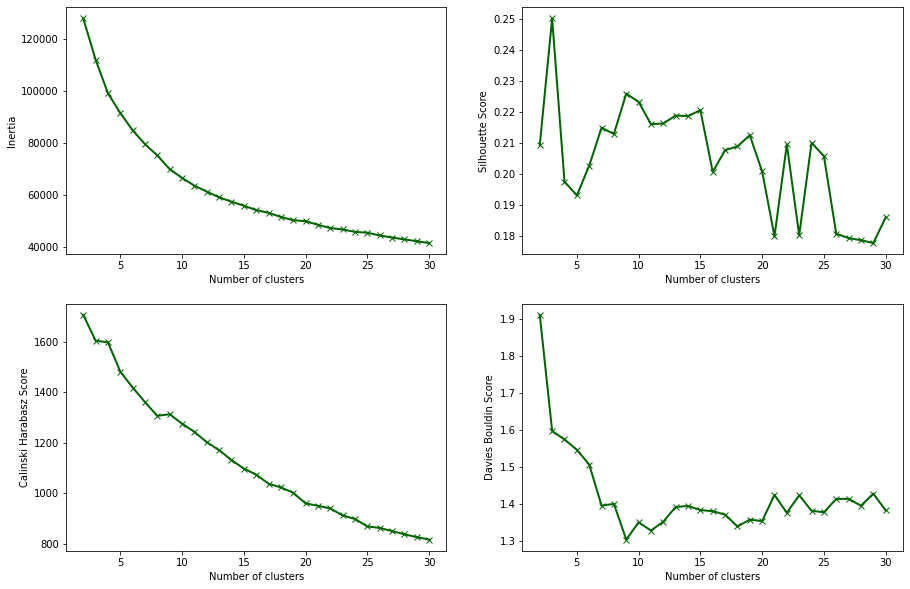

 Metric				 Best_K	 Score
 ------------------------------------------------------------
 Inertia			 30	 41609.405

 Silhouette Score		 3	 0.250

 Calinski Harabasz Score	 2	 1706.147

 Davies Bouldin Score		 9	 1.304



In [ ]:
# this time I also standardize the data to see how it affects the performance 
df = DP.standization()
evaluatation_metrics_for_KMeans(df, 2, 31)

In [ ]:
"""
 KMeans obtained a good Davies Bouldin Score with k = 11. Now, I cluster the data into 11 groups. 
 I also create a new dataframe with labels being added to the data.  
 """
df = pd.DataFrame(df)
def cluster_bestK(df,num):
  kmeans = KMeans(n_clusters=num)
  kmeans.fit(df)
  labels = kmeans.labels_
  clusters = pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
  clusters.groupby('cluster').mean()
  return clusters

In [ ]:
clusters = cluster_bestK(df,11)
print(clusters['cluster'].value_counts())

1     2442
2     1588
7     1082
10    1011
3      998
0      689
5      593
4      337
6      151
8       36
9       23
Name: cluster, dtype: int64


In [ ]:
clusters.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
cluster,,,,,,,,,,,,,,,,,
0,-0.705235,0.041269,-0.023458,-0.260731,0.422953,-0.456214,0.867916,-0.410793,1.029393,-0.655504,-0.466287,0.086881,-0.123231,-0.226434,-0.291281,2.156675,0.099308
1,-0.094980,0.395759,-0.356952,-0.237663,-0.407237,-0.165905,-0.860951,-0.379859,-0.777258,0.002835,-0.106190,-0.485188,-0.377319,-0.274512,-0.081722,-0.449596,0.275919
2,-0.214743,0.368640,-0.026805,-0.201614,0.306956,-0.323095,0.949653,-0.292338,1.147742,-0.398004,-0.313847,0.212476,-0.277977,-0.188562,-0.018492,-0.336177,0.282097
3,1.482751,0.416589,-0.289734,-0.211093,-0.297305,1.253016,-0.612157,-0.302398,-0.528343,1.589054,1.275607,-0.359115,0.826545,0.243129,0.345646,-0.450774,0.111350
4,1.031661,0.466726,2.569263,1.898272,2.587679,-0.167456,1.165349,1.631300,1.260845,-0.291175,-0.172127,3.198901,1.304064,1.433424,0.379452,0.241868,0.336289
5,-0.328387,-0.362792,-0.297070,-0.215798,-0.305553,0.079976,-0.246389,-0.285964,-0.267955,0.337122,0.014442,-0.396270,-0.572955,-0.394795,-0.207394,-0.077330,-3.235655
6,1.656247,0.303895,0.083470,0.110892,-0.006661,4.413540,-0.168784,0.088223,-0.133061,2.553740,4.004436,0.058832,1.291206,3.267014,0.492967,-0.126907,0.024174
7,-0.699163,-2.235501,-0.319860,-0.232453,-0.329084,-0.308631,-0.604929,-0.442347,-0.483556,-0.504348,-0.365965,-0.431354,-0.179927,-0.198393,-0.251570,0.113688,0.193552
8,1.290312,0.454124,-0.039755,-0.268864,0.399233,-0.000938,0.022469,-0.528409,0.262206,-0.252602,-0.060885,0.219536,-0.004964,-0.129901,11.641856,-0.525551,0.298409


##**$\color{darkorange}{\text{Step 5:}}$** Hieararchical clustering 

Now, I apply the agglomerative clustering algorithm and evaluate it using Silhouette score, Calinski Harabasz score, and Davies Bouldin score.


In [ ]:
"""
Similar to KMeans, this function evaluates AgglomerativeClustering for a range of K values and draws the performance plots in terms of three metrics
"""
def evaluatation_metrics_for_AggClus(df, min_clust, max_clust):
  silhouette = []
  ch_score = []
  db_score = []

  # Agglomerative clustering of data for different k values 
  for n_clust in range(min_clust, max_clust):
      hc = AgglomerativeClustering(n_clusters=n_clust)
      label = hc.fit_predict(df)
      # storing the scores in seprate lists
      silhouette.append(silhouette_score(df, label))
      ch_score.append(calinski_harabasz_score(df, label))
      db_score.append(davies_bouldin_score(df, label)) 

  # drawing the performance in terms of each metric as per each K value 
  metric_values = {0:silhouette, 1:ch_score, 2:db_score}
  metric_names =  ['Silhouette Score','Calinski Harabasz Score', 'Davies Bouldin Score']
  fig, ax = plt.subplots(1, 3, figsize=(10, 10))
  for i in range(3):
    ax[i].plot(range(min_clust, max_clust), metric_values[i], 'bx-', linewidth=2, color='darkgreen', )
    ax[i].set_xlabel('Number of clusters')
    ax[i].set_ylabel(metric_names[i])
  plt.subplots_adjust(left= 2, right=3) 
  plt.show()

  # prints a table that shows the best K values associated with each metric 
  print(' Metric\t\t\t\t Best_K\t Score\n','---'*20)
  print(' Silhouette Score\t\t %d\t %.3f\n' %(silhouette.index(max(silhouette))+2, max(silhouette))) 
  print(' Calinski Harabasz Score\t %d\t %.3f\n' %(ch_score.index(max(ch_score))+2, max(ch_score))) 
  print(' Davies Bouldin Score\t\t %d\t %.3f\n' %(db_score.index(min(db_score))+2, min(db_score))) 
  

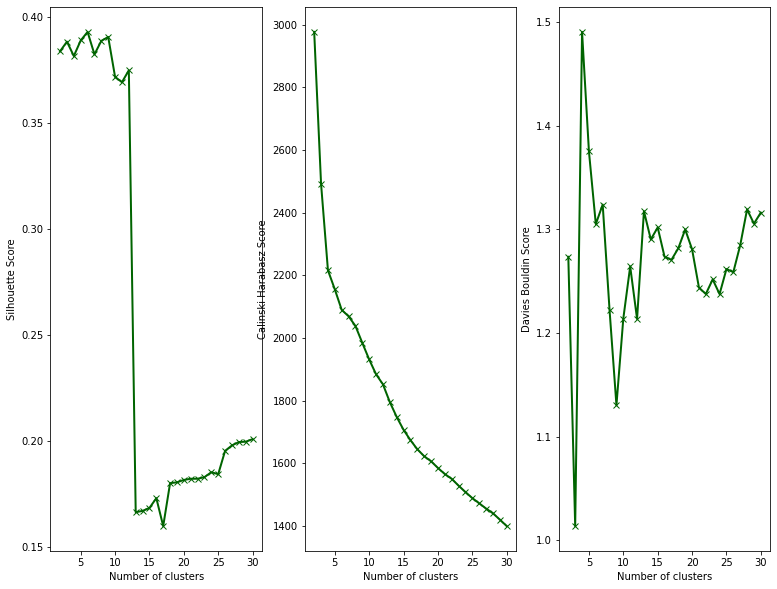

 Metric				 Best_K	 Score
 ------------------------------------------------------------
 Silhouette Score		 6	 0.393

 Calinski Harabasz Score	 2	 2976.524

 Davies Bouldin Score		 3	 1.014



In [ ]:
DP = data_preproccessing(credit_cards)
DP.missing_values()
DP.feature_selection()
df = DP.dataFrame
evaluatation_metrics_for_AggClus(df, 2, 31)

In [ ]:
""" 
Agglomerative clustering obtained a good Davies Bouldin Score with k = 2. 
Now, I cluster the data into 2 groups. I also create a new dataframe with labels being added to the data.  
"""
df = pd.DataFrame(df)
def cluster_bestK(df,num):
  kmeans = KMeans(n_clusters=num)
  kmeans.fit(df)
  labels = kmeans.labels_
  clusters = pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
  clusters.groupby('cluster').mean()
  return clusters

In [ ]:
clusters = cluster_bestK(df,2)
print(clusters['cluster'].value_counts())

0    7028
1    1922
Name: cluster, dtype: int64


In [ ]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,943.219295,0.860181,630.639249,329.825656,301.090867,537.420146,0.472024,0.163199,0.353246,0.109972,2.343625,11.072282,3037.466994,1031.899496,617.323997,0.154905,11.456460
1,3836.162593,0.939761,2365.531020,1552.705390,813.209579,2593.084115,0.557363,0.346012,0.405358,0.227188,6.558793,28.010926,9822.062719,4297.319366,1766.959160,0.149363,11.739854
